# 3 神经网络入门

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np

本章包括以下内容:

 神经网络的核心组件  
 Keras 简介  
 建立深度学习工作站   
 使用神经网络解决基本的分类问题与回归问题  

本章的目的是让你开始用神经网络来解决实际问题。  
你将进一步巩固在第 2 章第一个示例中学到的知识，还会将学到的知识应用于三个新问题，这三个问题涵盖神经网络最常见的三种使用场景:二分类问题、多分类问题和标量回归问题。  

本章将进一步介绍神经网络的核心组件，即层、网络、目标函数和优化器;  
还会简要介绍 Keras，它是贯穿本书的 Python 深度学习库。  
你还将建立深度学习工作站，安装好 TensorFlow 和 Keras，并支持 GPU。  
最后，我们将用三个介绍性示例深入讲解如何使用神经网络解决实际问题， 这三个示例分别是:  

 将电影评论划分为正面或负面(二分类问题)  
 将新闻按主题分类(多分类问题)  
 根据房地产数据估算房屋价格(回归问题)  

学完本章，你将能够使用神经网络解决简单的机器问题，比如对向量数据的分类问题和回归问题。  
然后，你就可以从第 4 章开始建立对机器学习更加具有原则性、理论性的理解。  

## 3.1 神经网络剖析

前面几章介绍过，训练神经网络主要围绕以下四个方面。

 **层**，多个层组合成**网络**(或**模型**)。<br>
 **输入数据**和相应的**目标**。  <br>
 **损失函数**，即用于学习的反馈信号。  <br>
 **优化器**，决定学习过程如何进行。  <br>

你可以将这四者的关系可视化，如图 3-1 所示:多个层链接在一起组成了网络，将输入数据映射为预测值。  
然后损失函数将这些预测值与目标进行比较，得到损失值，用于衡量网络预测值与预期结果的匹配程度。  
优化器使用这个损失值来更新网络的权重。 

<img src="./imgs/3.1.png"></img>

我们来进一步研究层、网络、损失函数和优化器。

### 3.1.1 层:深度学习的基础组件

我们在第 2 章中介绍过，神经网络的基本数据结构是**层**。  
层是一个数据处理模块，将一个或多个输入张量转换为一个或多个输出张量。  
有些层是无状态的，但大多数的层是有状态的， 即层的**权重**。<br>
权重是利用随机梯度下降学到的一个或多个张量，其中包含网络的**知识**。  

不同的张量格式与不同的数据处理类型需要用到不同的层。  
例如，简单的向量数据保存在形状为 (samples, features) 的 2D 张量中，通常用**密集连接层**[densely connected layer，也叫**全连接层**(fully connected layer)或**密集层**(dense layer)，对应于 Keras 的 Dense 类]来处理。  
序列数据保存在形状为 (samples, timesteps, features) 的 3D 张量中，通常用**循环层**(recurrent layer，比如 Keras 的 LSTM 层)来处理。  
图像数据保存在 4D 张量中，通常用二维卷积层(Keras 的 Conv2D)来处理。  

你可以将层看作深度学习的乐高积木，Keras 等框架则将这种比喻具体化。  
在 Keras 中，构建深度学习模型就是将相互兼容的多个层拼接在一起，以建立有用的数据变换流程。  
这里层兼容性(layer compatibility)具体指的是每一层只接受特定形状的输入张量，并返回特定形状的输出张量。  
看看下面这个例子。

In [1]:
from keras import layers

layer = layers.Dense(32, input_shape=(784,)) # 有 32 个输出单元的密集层

Using TensorFlow backend.


我们创建了一个层，只接受第一个维度大小为 784 的 2D 张量(第 0 轴是批量维度，其大小没有指定，因此可以任意取值)作为输入。  
这个层将返回一个张量，第一个维度的大小变成了 32。

因此，这个层后面只能连接一个接受 32 维向量作为输入的层。  
使用 Keras 时，你无须担心兼容性，因为向模型中添加的层都会自动匹配输入层的形状，例如下面这段代码。

In [2]:
from keras import models 
from keras import layers

model = models.Sequential() 
model.add(layers.Dense(32, input_shape=(784,))) 
model.add(layers.Dense(32))

Instructions for updating:
Colocations handled automatically by placer.


其中第二层没有输入形状(input_shape)的参数，相反，它可以自动推导出输入形状等于上一层的输出形状。  

### 3.1.2 模型:层构成的网络

深度学习模型是层构成的有向无环图。  
最常见的例子就是层的线性堆叠，将单一输入映射为单一输出。  

但随着深入学习，你会接触到更多类型的网络拓扑结构。  
一些常见的网络拓扑结构如下。

 双分支(two-branch)网络  
 多头(multihead)网络  
 Inception 模块  

网络的拓扑结构定义了一个**假设空间**(hypothesis space)。  
你可能还记得第 1 章里机器学习的定义:“在预先定义好的可能性空间中，利用反馈信号的指引来寻找输入数据的有用表示。” 选定了网络拓扑结构，意味着将**可能性空间**(假设空间)限定为一系列特定的张量运算，将输 6 入数据映射为输出数据。  
然后，你需要为这些张量运算的权重张量找到一组合适的值。  

选择正确的网络架构更像是一门艺术而不是科学。  
虽然有一些最佳实践和原则，但只有动手实践才能让你成为合格的神经网络架构师。  
后面几章将教你构建神经网络的详细原则，也会帮你建立直觉，明白对于特定问题哪些架构有用、哪些架构无用。  

### 3.1.3 损失函数与优化器:配置学习过程的关键

一旦确定了网络架构，你还需要选择以下两个参数。

#### 损失函数(目标函数)

在训练过程中需要将其最小化。  
它能够衡量当前任务是否已成功完成。

#### 优化器

决定如何基于损失函数对网络进行更新。  
它执行的是随机梯度下降(SGD)的某个变体。

具有多个输出的神经网络可能具有多个损失函数(每个输出对应一个损失函数)。  
但是，梯度下降过程必须基于**单个**标量损失值。  
因此，对于具有多个损失函数的网络，需要将所有损失函数取平均，变为一个标量值。  

选择正确的目标函数对解决问题是非常重要的。  
网络的目的是使损失尽可能最小化，因此，如果目标函数与成功完成当前任务不完全相关，那么网络最终得到的结果可能会不符合你的预期。  
想象一下，利用 SGD 训练一个愚蠢而又无所不能的人工智能，给它一个蹩脚的目标函数:“将所有活着的人的平均幸福感最大化”。  
为了简化自己的工作，这个人工智能可能会选择杀死绝大多数人类，只留几个人并专注于这几个人的幸福——因为平均幸福感并不受人数的影响。  
这可能并不是你想要的结果!  
请记住，你构建的所有神经网络在降低损失函数时和上述的人工智能一样无情。  
因此，一定要明智地选择目标函数，否则你将会遇到意想不到的副作用。  

幸运的是，对于分类、回归、序列预测等常见问题，你可以遵循一些简单的指导原则来选择正确的损失函数。  
例如，对于二分类问题，你可以使用二元交叉熵(binary crossentropy)损失函数;对于多分类问题，可以用分类交叉熵(categorical crossentropy)损失函数;对于回归问题，可以用均方误差(mean-squared error)损失函数;对于序列学习问题，可以用联结主义时序分类(CTC，connectionist temporal classification)损失函数，等等。  
只有在面对真正全新的研究问题时，你才需要自主开发目标函数。  
在后面几章里，我们将详细说明对于各种常见任务应选择哪种损失函数。

## 3.2 Keras 简介

本书的代码示例全都使用 Keras 实现。  
Keras 是一个 Python 深度学习框架，可以方便地定 义和训练几乎所有类型的深度学习模型。  
Keras 最开始是为研究人员开发的，其目的在于快速实验。  

Keras 具有以下重要特性。

 相同的代码可以在 CPU 或 GPU 上无缝切换运行。  
 具有用户友好的 API，便于快速开发深度学习模型的原型。  
 内置支持卷积网络(用于计算机视觉)、循环网络(用于序列处理)以及二者的任意组合。  
 支持任意网络架构:多输入或多输出模型、层共享、模型共享等。这也就是说，Keras能够构建任意深度学习模型，无论是生成式对抗网络还是神经图灵机。

Keras 基于宽松的 MIT 许可证发布，这意味着可以在商业项目中免费使用它。  
它与所有版本的 Python 都兼容(截至 2017 年年中，从 Python 2.7 到 Python 3.6 都兼容)。  

Keras 已有 200 000 多个用户，既包括创业公司和大公司的学术研究人员和工程师，也包括研究生和业余爱好者。  
Google、Netflix、Uber、CERN、Yelp、Square 以及上百家创业公司都在用 Keras 解决各种各样的问题。  
Keras 还是机器学习竞赛网站 Kaggle 上的热门框架，最新的深度学习竞赛中，几乎所有的优胜者用的都是Keras 模型，如图 3-2 所示。

<img src="./imgs/3.2.png"></img>

### 3.2.1 Keras、TensorFlow、Theano 和 CNTK

Keras 是一个模型级(model-level)的库，为开发深度学习模型提供了高层次的构建模块。   
`它不处理张量操作、求微分等低层次的运算`。<br>
相反，`它依赖于一个专门的、高度优化的张量库来完成这些运算`，这个张量库就是 Keras 的**后端引擎**(backend engine)。  
Keras 没有选择单个张量库并将 Keras 实现与这个库绑定，而是以模块化的方式处理这个问题(见图 3-3)。  
因此，几个不同的后端引擎都可以无缝嵌入到 Keras 中。  
目前，Keras 有三个后端实现:TensorFlow 后端、 Theano 后端和微软认知工具包(CNTK，Microsoft cognitive toolkit)后端。  
未来 Keras 可能会扩展到支持更多的深度学习引擎。  

<img src="./imgs/3.3.png"></img>

TensorFlow、CNTK 和 Theano 是当今深度学习的几个主要平台。  
Theano 由蒙特利尔大学的 MILA 实验室开发，TensorFlow 由 Google 开发，CNTK 由微软开发。  
你用 Keras 写的每一段代码都可以在这三个后端上运行，无须任何修改。  
也就是说，你在开发过程中可以在两个后端之间无缝切换，这通常是很有用的。  
例如，对于特定任务，某个后端的速度更快，那么我们就可以无缝切换过去。  
我们推荐使用 TensorFlow 后端作为大部分深度学习任务的默认后端，因为它的应用最广泛，可扩展，而且可用于生产环境。

通过 TensorFlow(或 Theano、CNTK)，Keras 可以在 CPU 和 GPU 上无缝运行。  
在 CPU 上运行 时，TensorFlow 本身封装了一个低层次的张量运算库，叫作 Eigen;在 GPU 上运行时，TensorFlow 封装了一个高度优化的深度学习运算库，叫作 NVIDIA CUDA 深度神经网络库(cuDNN)。

### 3.2.2 使用 Keras 开发:概述

你已经见过一个 Keras 模型的示例，就是 MNIST 的例子。  
典型的 Keras 工作流程就和那个例子类似。  

(1) 定义训练数据:输入张量和目标张量。  
(2) 定义层组成的网络(或模型)，将输入映射到目标。  
(3) 配置学习过程:选择损失函数、优化器和需要监控的指标。  
(4) 调用模型的fit方法在训练数据上进行迭代。  

定义模型有两种方法:一种是使用 Sequential 类(仅用于层的线性堆叠，这是目前最常见的网络架构)，另一种是**函数式 API**(functional API，用于层组成的有向无环图，让你可以构建任意形式的架构)。

前面讲过，这是一个利用 Sequential类定义的两层模型(注意，我们向第一层传入了输入数据的预期形状)。  

In [3]:
from keras import models 
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,))) 
model.add(layers.Dense(10, activation='softmax'))

下面是用函数式 API 定义的相同模型。

In [4]:
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor) 
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

利用函数式 API，你可以操纵模型处理的数据张量，并将层应用于这个张量，就好像这些层是函数一样。  

**注意** 第 7 章有关于函数式 API 的详细指南。在那之前，我们的代码示例中只会用到 Sequential 类。

一旦定义好了模型架构，使用 Sequential 模型还是函数式 API 就不重要了。  
接下来的步骤都是相同的。  

配置学习过程是在编译这一步，你需要指定模型使用的优化器和损失函数，以及训练过程中想要监控的指标。  
下面是单一损失函数的例子，这也是目前最常见的。  

In [5]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='mse',
              metrics=['accuracy'])

最后，学习过程就是通过 fit() 方法将输入数据的 Numpy 数组(和对应的目标数据)传入模型，这一做法与 Scikit-Learn 及其他机器学习库类似。  

In [7]:
# model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)

在接下来的几章里，你将会在这些问题上培养可靠的直觉:  
哪种类型的网络架构适合解决哪种类型的问题?  
如何选择正确的学习配置?  
如何调节模型使其给出你想要的结果?  
我们将在 3.4~3.6 节讲解三个基本示例，分别是二分类问题、多分类问题和回归问题。  

### 3.3 建立深度学习工作站

在开始开发深度学习应用之前，你需要建立自己的深度学习工作站。  
虽然并非绝对必要，但强烈推荐你在现代 NVIDIA GPU 上运行深度学习实验。  
某些应用，特别是卷积神经网络的图像处理和循环神经网络的序列处理，在 CPU 上的速度非常之慢，即使是高速多核 CPU 也是如此。   
即使是可以在 CPU 上运行的深度学习应用，使用现代 GPU 通常也可以将速度提高 5 倍或 10 倍。   
如果你不想在计算机上安装 GPU，也可以考虑在 AWS EC2 GPU 实例或 Google 云平台上运行深 度学习实验。  
但请注意，时间一长，云端 GPU 实例可能会变得非常昂贵。  

无论在本地还是在云端运行，最好都使用 UNIX 工作站。  
虽然从技术上来说可以在 Windows 上 使 用 K e r a s ( K e r a s 的 三 个 后 端 都 支 持 W i n d o w s )， 但 我 们 不 建 议 这 么 做 。   
在 附 录 A 的 安 装 说 明 中 ， 我们以安装了 Ubuntu 的计算机为例。  
如果你是 Windows 用户，最简单的解决方案就是安装 Ubuntu 双系统。  
这看起来可能有点麻烦，但从长远来看，使用 Ubuntu 将会为你省去大量时间和麻烦。  

注意，使用 Keras 需要安装 TensorFlow、CNTK 或 Theano(如果你希望能够在三个后端之间 来回切换，那么可以安装三个)。  
本书将重点介绍 TensorFlow，并简要介绍一下 Theano，不会涉 及 CNTK。  

### 3.3.1 Jupyter 笔记本:运行深度学习实验的首选方法

Jupyter 笔记本是运行深度学习实验的好方法，特别适合运行本书中的许多代码示例。  
它广泛用于数据科学和机器学习领域。  
**笔记本**(notebook)是 Jupyter Notebook 应用生成的文件，可以在浏览器中编辑。  
它可以执行 Python 代码，还具有丰富的文本编辑功能，可以对代码进行注释。  
笔记本还可以将冗长的实验代码拆分为可独立执行的短代码，这使得开发具有交互性，而且如果后面的代码出现问题，你也不必重新运行前面的所有代码。  

我们推荐使用 Jupyter 笔记本来上手 Keras，虽然这并不是必需的。  
你也可以运行独立的 Python 脚本，或者在 IDE(比如 PyCharm)中运行代码。  
本书所有代码示例都以开源笔记本的形式提供，你可以在本书网站上下载:https://www.manning.com/books/deep-learning-with-python。  

### 3.3.2 运行 Keras:两种选择

想要在实践中使用 Keras，我们推荐以下两种方式。

 1、使用官方的 EC2 深度学习 Amazon 系统映像(AMI)，并在 EC2 上以 Jupyter 笔记本的方式运行 Keras 实验。如果你的本地计算机上没有 GPU，你可以选择这种方式。附录 B 给出了详细指南。  
 2、在本地 UNIX 工作站上从头安装。然后你可以运行本地 Jupyter 笔记本或常规的 Python代码库。如果你已经拥有了高端的 NVIDIA GPU，可以选择这种方式。附录 A 给出了基于 Ubuntu 的详细安装指南。

我们来详细看一下这两种方式的优缺点。

### 3.3.3 在云端运行深度学习任务:优点和缺点

如果你还没有可用于深度学习的 GPU(即最新的高端 NVIDIA GPU)，那么在云端运行深度学习实验是一种简单又低成本的方法，让你无须额外购买硬件就可以上手。  
如果你使用 Jupyter 笔记本，那么在云端运行的体验与在本地运行完全相同。  
截至 2017 年年中，最容易上手深度学习的云产品肯定是 AWS EC2。  
附录 B 给出了在 EC2 GPU 实例上运行 Jupyter 笔记本的详细指南。  

但如果你是深度学习的重度用户，从长期来看这种方案是难以持续的，甚至几个星期都不行。  
EC2 实例的价格很高:附录 B 推荐的实例(p2.xlarge 实例，计算能力一般)在 2017 年年中的价格是每小时 0.90 美元。  
与此相对的是，一款可靠的消费级 GPU 价格在 1000~1500 美 元——这个价格一直相当稳定，而这种 GPU 的性能则在不断提高。  
如果你准备认真从事深度学习，那么应该建立具有一块或多块 GPU 的本地工作站。  

简而言之，EC2 是很好的上手方法。  
你完全可以在 EC2 GPU 实例上运行本书的代码示例。   
但如果你想成为深度学习的高手，那就自己买 GPU。  

### 3.3.4 深度学习的最佳 GPU

如果你准备买一块 GPU，应该选择哪一款呢?  
首先要注意，一定要买 NVIDIA GPU。   
NVIDIA 是目前唯一一家在深度学习方面大规模投资的图形计算公司，  
现代深度学习框架只能在 NVIDIA 显卡上运行。  

截至 2017 年年中，我们推荐 NVIDIA TITAN Xp 为市场上用于深度学习的最佳显卡。  
如果预算较少，你也可以考虑 GTX 1060。  
如果你读到本节的时间是在 2018 年或更晚，请花点时间在网上查找最新的推荐，因为每年都会推出新的模型。  

从这一节开始，我们将认为你的计算机已经安装好 Keras 及其依赖，最好支持 GPU。  
在继续阅读之前请确认已经完成此步骤。  
阅读附录中的详细指南，还可以在网上搜索进一步的帮助。   
安装 Keras 及常见的深度学习依赖的教程有很多。  

下面我们将深入讲解 Keras 示例。

## 3.4 电影评论分类:二分类问题

二分类问题可能是应用最广泛的机器学习问题。  
在这个例子中，你将学习根据电影评论的文字内容将其划分为正面或负面。  

### 3.4.1 IMDB 数据集

本节使用 IMDB 数据集，它包含来自互联网电影数据库(IMDB)的 50 000 条严重两极分化的评论。  
数据集被分为用于训练的 25 000 条评论与用于测试的 25 000 条评论，训练集和测试集都包含50% 的正面评论和 50% 的负面评论。  

为什么要将训练集和测试集分开?  
因为你不应该将训练机器学习模型的同一批数据再用于测试模型!  
模型在训练数据上的表现很好，并不意味着它在前所未见的数据上也会表现得很好，而且你真正关心的是模型在新数据上的性能(因为你已经知道了训练数据对应的标签，显然不再需要模型来进行预测)。  
例如，你的模型最终可能只是记住了训练样本和目标值之间的映射关系，但这对在前所未见的数据上进行预测毫无用处。  
下一章将会更详细地讨论这一点。  

与 MNIST 数据集一样，IMDB 数据集也内置于 Keras 库。  
它已经过预处理:评论(单词序列) 已经被转换为整数序列，其中每个整数代表字典中的某个单词。  

下列代码将会加载 IMDB 数据集(第一次运行时会下载大约 80MB 的数据)。

**加载 IMDB 数据集**

In [12]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data( num_words=10000)

参数 num_words=10000 的意思是仅保留训练数据中前 10 000 个最常出现的单词。  
低频单词将被舍弃。  
这样得到的向量数据不会太大，便于处理。  

train_data 和 test_data 这两个变量都是评论组成的列表，每条评论又是单词索引组成的列表(表示一系列单词)。  
train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0 代表负面(negative)，1 代表正面(positive)。  

In [13]:
train_data[0]
train_labels[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

1

由于限定为前 10 000 个最常见的单词，单词索引都不会超过 10 000。

In [14]:
max([max(sequence) for sequence in train_data])

9999

下面这段代码很有意思，你可以将某条评论迅速解码为英文单词。

In [16]:
word_index = imdb.get_word_index() # word_index 是一个将单词映射为整数索引的字典 
reverse_word_index = dict(  
    [(value, key) for (key, value) in word_index.items()]) #键值颠倒，将整数索引映射为单词
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])
    # 将评论解码。注意，索引减去了 3，因为 0、1、2是为“padding”(填充)、“start of sequence”(序列开始)、“unknown”(未知词)分别保留的索引

1646592/1641221 [==============================] - 124s 75us/step


### 3.4.2 准备数据

你不能将整数序列直接输入神经网络。  
你需要将列表转换为张量。  
转换方法有以下两种。

 1、填充列表，使其具有相同的长度，再将列表转换成形状为 (samples, word_indices) 的整数张量，然后网络第一层使用能处理这种整数张量的层(即 Embedding 层，本书后面会详细介绍)。  
 2、对列表进行 one-hot 编码，将其转换为 0 和 1 组成的向量。举个例子，序列 [3, 5] 将会被转换为 10 000 维向量，只有索引为 3 和 5 的元素是 1，其余元素都是 0。然后网络第
一层可以用 Dense 层，它能够处理浮点数向量数据。

下面我们采用后一种方法将数据向量化。  
为了加深理解，你可以手动实现这一方法，如下所示。

**将整数序列编码为二进制矩阵**

In [17]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): 
    results = np.zeros((len(sequences), dimension)) # 创建一个形状为 (len(sequences), dimension) 的零矩阵
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # 将 results[i] 的指定索引设为 1 
    return results

x_train = vectorize_sequences(train_data)  # 将训练数据向量化
x_test = vectorize_sequences(test_data) # 将测试数据向量化

In [18]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

你还应该将标签向量化，这很简单。

In [19]:
y_train = np.asarray(train_labels).astype('float32') 
y_test = np.asarray(test_labels).astype('float32')

现在可以将数据输入到神经网络中。

### 3.4.3 构建网络

输入数据是向量，而标签是标量(1 和 0)，这是你会遇到的最简单的情况。  
有一类网络在这种问题上表现很好，就是带有 relu 激活的全连接层(Dense)的简单堆叠，比如 Dense(16, activation='relu')。  

传入 Dense 层的参数(16)是该层隐藏单元的个数。  
一个**隐藏单元**(hidden unit)是该层表示空间的一个维度。  
我们在第 2 章讲过，每个带有 relu 激活的 Dense 层都实现了下列张量运算:  

In [20]:
# output = relu(dot(W, input) + b)

16 个隐藏单元对应的权重矩阵 W 的形状为 (input_dimension, 16)，与 W 做点积相当于将输入数据投影到 16 维表示空间中(然后再加上偏置向量 b 并应用 relu 运算)。  
你可以将表示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。  
隐藏单元越多(即更高维 的表示空间)，网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导致学到不好的模式(这种模式会提高训练数据上的性能，但不会提高测试数据上的性能)。  

对于这种 Dense 层的堆叠，你需要确定以下两个关键架构:

 1、网络有多少层;  
 2、每层有多少个隐藏单元。 

第 4 章中的原则将会指导你对上述问题做出选择。  
现在你只需要相信我选择的下列架构:

 1、两个中间层，每层都有 16 个隐藏单元;  
 2、第三层输出一个标量，预测当前评论的情感。

中间层使用 relu 作为激活函数，最后一层使用 sigmoid 激活以输出一个 0~1 范围内的概率值(表示样本的目标值等于 1 的可能性，即评论为正面的可能性)。  
relu(rectified linear unit， 整流线性单元)函数将所有负值归零(见图 3-4)，而 sigmoid 函数则将任意值“压缩”到 [0, 1] 区间内(见图 3-5)，其输出值可以看作概率值。

<img src="./imgs/3.4.png"></img>

<img src="./imgs/3.5.png"></img>

图 3-6 显示了网络的结构。代码清单 3-3 是其 Keras 实现，与前面见过的 MNIST 例子类似。

<img src="./imgs/3.6.png"></img>

**模型定义**

In [21]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(16, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

**什么是激活函数?为什么要使用激活函数?**

如果没有 relu 等激活函数(也叫**非线性**)，Dense 层将只包含两个线性运算——点积和加法:  
output = dot(W, input) + b  
这样 Dense 层就只能学习输入数据的**线性变换**(仿射变换):该层的**假设空间**是从输入数据到 16 位空间所有可能的线性变换集合。  
这种假设空间非常有限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍是线性运算，添加层数并不会扩展假设空间。  
为了得到更丰富的假设空间，从而充分利用多层表示的优势，你需要添加非线性或激活函数。  
relu 是深度学习中最常用的激活函数，但还有许多其他函数可选，它们都有类似的奇怪名称，比如 prelu、elu 等。  

最后，你需要选择损失函数和优化器。  
由于你面对的是一个二分类问题，网络输出是一个概率值(网络最后一层使用 sigmoid 激活函数，仅包含一个单元)，那么最好使用 binary_ crossentropy(二元交叉熵)损失。  
这并不是唯一可行的选择，比如你还可以使用 mean_ squared_error(均方误差)。  
但对于输出概率值的模型，**交叉熵**(crossentropy)往往是最好的选择。  
交叉熵是来自于信息论领域的概念，用于衡量概率分布之间的距离，在这个例子中就是真实分布与预测值之间的距离。  

下面的步骤是用 rmsprop 优化器和 binary_crossentropy 损失函数来配置模型。  
注意，我们还在训练过程中监控精度。  

**编译模型**

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

上述代码将优化器、损失函数和指标作为字符串传入，这是因为 rmsprop、binary_crossentropy 和 accuracy 都是 Keras 内置的一部分。  
有时你可能希望配置自定义优化器的参数，或者传入自定义的损失函数或指标函数。  
前者可通过向 optimizer 参数传入一个优化器类实例来实现，如代码清单 3-5 所示;  
后者可通过向 loss 和 metrics 参数传入函数对象来实现， 如代码清单 3-6 所示。  

3-5  **配置优化器**

In [23]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

3-6 **使用自定义的损失和指标**

In [24]:
from keras import losses 
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### 3.4.4 验证你的方法

为了在训练过程中监控模型在前所未见的数据上的精度，你需要将原始训练数据留出 10 000 个样本作为验证集。  

**留出验证集**

In [25]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000] 
partial_y_train = y_train[10000:]

现在使用 512 个样本组成的小批量，将模型训练 20 个轮次(即对 x_train 和 y_train 两 个张量中的所有样本进行 20 次迭代)。  
与此同时，你还要监控在留出的 10 000 个样本上的损失和精度。  
你可以通过将验证数据传入validation_data 参数来完成。  

**训练模型**

In [26]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs=20,
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 200us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8684
Epoch 2/20
15000/15000 [==============================] - 2s 125us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8897
Epoch 3/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3085 - val_acc: 0.8711
Epoch 4/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1750 - acc: 0.9437 - val_loss: 0.2840 - val_acc: 0.8832
Epoch 5/20
15000/15000 [==============================] - 2s 122us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2841 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.1150 - acc: 0.9650 - val_loss: 0.3166 - val_acc: 0.8772
Epoch 7/20
15000/15000 [==============================] - 2s 106us/step - 

在 CPU 上运行，每轮的时间不到 2 秒，训练过程将在 20 秒内结束。  
每轮结束时会有短暂的停顿，因为模型要计算在验证集的 10 000 个样本上的损失和精度。  

注意，调用 model.fit() 返回了一个 History 对象。  
这个对象有一个成员 history，它是一个字典，包含训练过程中的所有数据。我们来看一下。  

In [27]:
history_dict=history.history

In [28]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

字典中包含 4 个条目，对应训练过程和验证过程中监控的指标。  
在下面两个代码清单中， 我们将使用 Matplotlib 在同一张图上绘制训练损失和验证损失，以及训练精度和验证精度。  
请注意，由于网络的随机初始化不同，你得到的结果可能会略有不同。  

3-9 **绘制训练损失和验证损失**

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

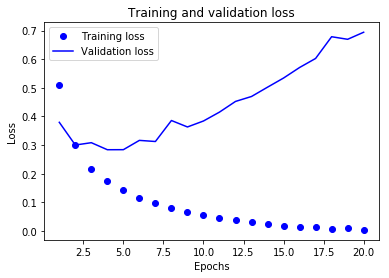

In [31]:
import matplotlib.pyplot as plt
history_dict = history.history 
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # 'bo' 表示蓝色圆点
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # 'b' 表示蓝色实线
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()

3-10 **绘制训练精度和验证精度**

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

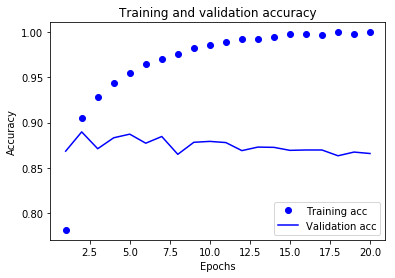

In [32]:
plt.clf() #清空图像
acc = history_dict['acc'] 
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()

plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。  
这就是梯度下降优化的预期结果——你想要最小化的量随着每次迭代越来越小。  
但验证损失和验证精度并非如此:它们似乎在第四轮达到最佳值。  
这就是我们之前警告过的一种情况:模型在训练数据上的表现越来越好，但在前所未见的数据上不一定表现得越来越好。  
准确地说，你看到的是过拟合(overfit):在第二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之外的数据。  

在这种情况下，为了防止过拟合，你可以在 3 轮之后停止训练。  
通常来说，你可以使用许多方法来降低过拟合，我们将在第 4 章中详细介绍。  

我们从头开始训练一个新的网络，训练 4 轮，然后在测试数据上评估模型。

**从头开始重新训练一个模型**

In [33]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(16, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512) 
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 77us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 2s 65us/step - loss: 0.2651 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 2s 63us/step - loss: 0.1982 - acc: 0.9298
Epoch 4/4
25000/25000 [==============================] - 2s 63us/step - loss: 0.1673 - acc: 0.9410


25000/25000 [==============================] - 3s 119us/step


In [34]:
results

[0.3231773455619812, 0.87292]

这种相当简单的方法得到了 88% 的精度。  
利用最先进的方法，你应该能够得到接近 95% 的 精度。  

### 3.4.5 使用训练好的网络在新数据上生成预测结果

训练好网络之后，你希望将其用于实践。  
你可以用 predict 方法来得到评论为正面的可能性大小。

In [35]:
model.predict(x_test)

array([[0.1392012 ],
       [0.9996873 ],
       [0.3057804 ],
       ...,
       [0.07081527],
       [0.04415584],
       [0.4680246 ]], dtype=float32)

如你所见，网络对某些样本的结果非常确信(大于等于 0.99，或小于等于 0.01)，  
但对其他结果却不那么确信(0.6 或 0.4)。  

### 3.4.6 进一步的实验

通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间。

 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测试精度的影响。  
 尝试使用更多或更少的隐藏单元，比如 32 个、64 个等。  
 尝试使用 mse 损失函数代替 binary_crossentropy。  
 尝试使用 tanh 激活(这种激活在神经网络早期非常流行)代替 relu。  

### 3.4.7 小结

In [ ]:
'''
1、通常需要对原始数据进行大量预处理，以便将其转换为张量输入到神经网络中。
单词序列可以编码为二进制向量，但也有其他编码方式。  
2、带有 relu 激活的 Dense 层堆叠，可以解决很多种问题(包括情感分类)，你可能会经
常用到这种模型。  
3、对于二分类问题(两个输出类别)，网络的最后一层应该是只有一个单元并使用 sigmoid
激活的 Dense 层，网络输出应该是 0~1 范围内的标量，表示概率值。  
4、对于二分类问题的 sigmoid 标量输出，你应该使用 binary_crossentropy 损失函数。  
5、无论你的问题是什么，rmsprop 优化器通常都是足够好的选择。这一点你无须担心。  
6、随着神经网络在训练数据上的表现越来越好，模型最终会过拟合，并在前所未见的数据上得到越来越差的结果。
一定要一直监控模型在训练集之外的数据上的性能。  
'''

## 3.5 新闻分类:多分类问题

上一节中，我们介绍了如何用密集连接的神经网络将向量输入划分为两个互斥的类别。但如果类别不止两个，要怎么做?

本节你会构建一个网络，将路透社新闻划分为 46 个互斥的主题。  
因为有多个类别，所以这是**多分类**(multiclass classification)问题的一个例子。  
因为每个数据点只能划分到一个类别，所以更具体地说，这是**单标签**、**多分类**(single-label, multiclass classification)问题的一个例子。   
如果每个数据点可以划分到多个类别(主题)，那它就是一个**多标签**、**多分类**(multilabel, multiclass classification)问题。

### 3.5.1 路透社数据集

本节使用**路透社数据集**，它包含许多短新闻及其对应的主题，由路透社在 1986 年发布。  
它是一个简单的、广泛使用的文本分类数据集。  
它包括 46 个不同的主题:某些主题的样本更多，但训练集中每个主题都有至少 10 个样本。  

与 IMDB 和 MNIST 类似，路透社数据集也内置为 Keras 的一部分。  
我们来看一下。  

**加载路透社数据集**

In [36]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data( num_words=10000)

2113536/2110848 [==============================] - 44s 21us/step


与 IMDB 数据集一样，参数 num_words=10000 将数据限定为前 10 000 个最常出现的单词。  我们有 8982 个训练样本和 2246 个测试样本。  

In [37]:
len(train_data)
len(test_data)

8982

2246

与 IMDB 评论一样，每个样本都是一个整数列表(表示单词索引)。

In [38]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

如果好奇的话，你可以用下列代码将索引解码为单词。

**将索引解码为新闻文本**

In [39]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
# 注意，索引减去了 3，因为 0、1、2 是为“padding”(填充)、“start of sequence”(序列开始)、“unknown”(未知词)分别保留的索引

557056/550378 [==============================] - 14s 25us/step


样本对应的标签是一个 0~45 范围内的整数，即话题索引编号。

### 3.5.2 准备数据

**编码数据**

In [40]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): 
    results = np.zeros((len(sequences), dimension)) 
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. 
    return results

x_train = vectorize_sequences(train_data)  # 将训练数据向量化
x_test = vectorize_sequences(test_data)  # 将测试数据向量化

将标签向量化有两种方法:你可以将标签列表转换为整数张量，或者使用 one-hot 编码。  
one-hot 编码是分类数据广泛使用的一种格式，也叫分类编码(categorical encoding)。  
6.1 节给出了 one-hot 编码的详细解释。  
在这个例子中，标签的 one-hot 编码就是将每个标签表示为全零向量，只有标签索引对应的元素为 1。  
其代码实现如下。

In [42]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension)) 
    for i, label in enumerate(labels):
        results[i, label] = 1. 
    return results

one_hot_train_labels = to_one_hot(train_labels) # 将训练标签向量化
one_hot_test_labels = to_one_hot(test_labels) # 将测试标签向量化

注意，Keras 内置方法可以实现这个操作，你在 MNIST 例子中已经见过这种方法。

In [43]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels) 
one_hot_test_labels = to_categorical(test_labels)

### 3.5.3 构建网络

这个主题分类问题与前面的电影评论分类问题类似，两个例子都是试图对简短的文本片段进行分类。  
但这个问题有一个新的约束条件:输出类别的数量从 2 个变为 46 个。  
输出空间的维度要大得多。

对于前面用过的 Dense 层的堆叠，每层只能访问上一层输出的信息。  
如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。  
上一个例子使用了 16 维的中间层，但对这个例子来说 16 维空间可能太小了，无法学会区分 46 个不同的类别。  
这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。  

出于这个原因，下面将使用维度更大的层，包含 64 个单元。

**模型定义**

In [44]:
from keras import models 
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(46, activation='softmax'))

关于这个架构还应该注意另外两点。

 1、网络的最后一层是大小为 46 的 Dense 层。这意味着，对于每个输入样本，网络都会输
出一个 46 维向量。这个向量的每个元素(即每个维度)代表不同的输出类别。  
 2、最后一层使用了 softmax 激活。你在 MNIST 例子中见过这种用法。网络将输出在 46
个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个 46 维向量，
其中 output[i] 是样本属于第 i 个类别的概率。46 个概率的总和为 1。

对于这个例子，最好的损失函数是 categorical_crossentropy(分类交叉熵)。  
它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。  
通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

**编译模型**

In [45]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.4 验证你的方法

我们在训练数据中留出 1000 个样本作为验证集。

**留出验证集**

In [46]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000] 
partial_y_train = one_hot_train_labels[1000:]

现在开始训练网络，共 20 个轮次。

**训练模型**

In [47]:
history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 195us/step - loss: 2.5241 - acc: 0.4977 - val_loss: 1.7183 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 112us/step - loss: 1.4443 - acc: 0.6888 - val_loss: 1.3500 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 1s 131us/step - loss: 1.0991 - acc: 0.7645 - val_loss: 1.1754 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.8728 - acc: 0.8160 - val_loss: 1.0809 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 137us/step - loss: 0.7062 - acc: 0.8492 - val_loss: 0.9862 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 134us/step - loss: 0.5696 - acc: 0.8794 - val_loss: 0.9417 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 118us/step - loss: 0.4625 - acc: 0.9033 - val_loss: 0.9076 - val_acc: 0.8030


最后，我们来绘制损失曲线和精度曲线。

**绘制训练损失和验证损失**

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

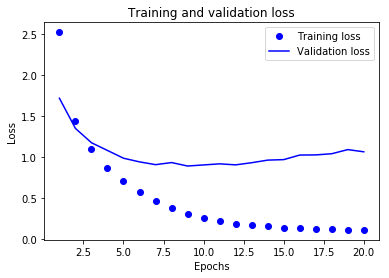

In [48]:
import matplotlib.pyplot as plt

loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()

plt.show()

**绘制训练精度和验证精度**

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

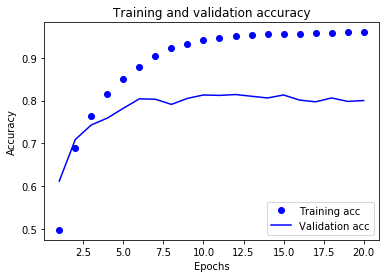

In [49]:
plt.clf() # 清空图像

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()

plt.show()

网络在训练 9 轮后开始过拟合。我们从头开始训练一个新网络，共 9 个轮次，然后在测试集上评估模型。

**从头开始重新训练一个模型**

In [50]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512, 
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 171us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 125us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 127us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 120us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 123us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 115us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 121us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

2246/2246 [==============================] - 0s 88us/step


In [51]:
results

[1.0224983078607575, 0.7756010686194165]

这种方法可以得到约 80% 的精度。  
对于平衡的二分类问题，完全随机的分类器能够得到 50% 的精度。  
但在这个例子中，完全随机的精度约为 19%，所以上述结果相当不错，至少和随机的基准比起来还不错。

In [52]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

### 3.5.5 在新数据上生成预测结果

你可以验证，模型实例的 predict 方法返回了在 46 个主题上的概率分布。  
我们对所有测试数据生成主题预测。  

**在新数据上生成预测结果**

In [53]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [54]:
np.sum(predictions[0]) #这个向量的所有元素总和为 1。

0.9999998

In [55]:
np.argmax(predictions[0]) #最大的元素就是预测类别，即概率最大的类别。

3

### 3.5.6 处理标签和损失的另一种方法

前面提到了另一种编码标签的方法，就是将其转换为整数张量，如下所示。

In [56]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

对于这种编码方法，唯一需要改变的是损失函数的选择。  
对于代码清单 3-21 使用的损失 函数 categorical_crossentropy，标签应该遵循分类编码。  对于整数标签，你应该使用sparse_categorical_crossentropy。  

In [ ]:
'''
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])
'''

这个新的损失函数在数学上与 categorical_crossentropy 完全相同，二者只是接口不同。

### 3.5.7 中间层维度足够大的重要性

前面提到，最终输出是 46 维的，因此中间层的隐藏单元个数不应该比 46 小太多。  
现在来看一下，如果中间层的维度远远小于 46(比如 4 维)，造成了信息瓶颈，那么会发生什么?  

**具有信息瓶颈的模型**

In [59]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128, 
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 194us/step - loss: 2.6576 - acc: 0.3772 - val_loss: 1.9685 - val_acc: 0.5280
Epoch 2/20
7982/7982 [==============================] - 1s 124us/step - loss: 1.6654 - acc: 0.6213 - val_loss: 1.5406 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 1s 134us/step - loss: 1.3322 - acc: 0.6708 - val_loss: 1.3942 - val_acc: 0.6810
Epoch 4/20
7982/7982 [==============================] - 1s 128us/step - loss: 1.1418 - acc: 0.7273 - val_loss: 1.3241 - val_acc: 0.6980
Epoch 5/20
7982/7982 [==============================] - 1s 130us/step - loss: 1.0106 - acc: 0.7459 - val_loss: 1.2707 - val_acc: 0.7000
Epoch 6/20
7982/7982 [==============================] - 1s 132us/step - loss: 0.9094 - acc: 0.7577 - val_loss: 1.2780 - val_acc: 0.7070
Epoch 7/20
7982/7982 [==============================] - 1s 132us/step - loss: 0.8302 - acc: 0.7741 - val_loss: 1.2592 - val_acc: 0.7090


现在网络的验证精度最大约为 71%，比前面下降了 8%。  
导致这一下降的主要原因在于，你试图将大量信息(这些信息足够恢复 46 个类别的分割超平面)压缩到维度很小的中间空间。  
网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。  

### 3.5.8 进一步的实验

 尝试使用更多或更少的隐藏单元，比如 32 个、128 个等。  
 前面使用了两个隐藏层，现在尝试使用一个或三个隐藏层。

### 3.5.9 小结

 1、如果要对 N 个类别的数据点进行分类，网络的最后一层应该是大小为 N 的 Dense 层。  
 2、对于单标签、多分类问题，网络的最后一层应该使用 softmax 激活，这样可以输出在 N
   个输出类别上的概率分布。  
 3、这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的
   真实分布之间的距离最小化。  
 4、处理多分类问题的标签有两种方法。  
 5、通过分类编码(也叫 one-hot 编码)对标签进行编码，然后使用categorical_ crossentropy 作为损失函数。  
 6、将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数。  
 7、如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成
信息瓶颈。  

## 3.6 预测房价:回归问题

前面两个例子都是分类问题，其目标是预测输入数据点所对应的单一离散的标签。  
另一种常见的机器学习问题是回归问题，它预测一个连续值而不是离散的标签，例如，根据气象数据 预测明天的气温，或者根据软件说明书预测完成软件项目所需要的时间。  

**注意** 不要将回归问题与 logistic 回归算法混为一谈。令人困惑的是，logistic 回归不是回归算法， 而是分类算法。  

### 3.6.1 波士顿房价数据集

本节将要预测 20 世纪 70 年代中期波士顿郊区房屋价格的中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。  
本节用到的数据集与前面两个例子有一个有趣的区别。   
它包含的数据点相对较少，只有 506 个，分为 404 个训练样本和 102 个测试样本。输入数据的 每个特征(比如犯罪率)都有不同的取值范围。  
例如，有些特性是比例，取值范围为 0~1;有的取值范围为 1~12;还有的取值范围为 0~100，等等。

**加载波士顿房价数据**

In [62]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 11s 198us/step


我们来看一下数据。

In [63]:
train_data.shape
test_data.shape

(404, 13)

(102, 13)

如你所见，我们有 404 个训练样本和 102 个测试样本，每个样本都有 13 个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。  

目标是房屋价格的中位数，单位是千美元。

In [64]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

房价大都在 10 000~50 000 美元。  
如果你觉得这很便宜，不要忘记当时是 20 世纪 70 年代中期，而且这些价格没有根据通货膨胀进行调整。

### 3.6.2 准备数据

将取值范围差异很大的数据输入到神经网络中，这是有问题的。  
网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。  
对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对于输入数据的每个特征(输入数据矩阵中的列)，减去特征平均值，再除 7 以标准差，这样得到的特征平均值为 0，标准差为 1。  
用 Numpy 可以很容易实现标准化。  

**数据标准化**

In [65]:
mean = train_data.mean(axis=0) 
train_data -= mean
std = train_data.std(axis=0) 
train_data /= std

test_data -= mean 
test_data /= std

注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。  
在工作流程中，你不能使用在测试数据上计算得到的任何结果，即使是像数据标准化这么简单的事情也不行。  

### 3.6.3 构建网络

由于样本数量很少，我们将使用一个非常小的网络，其中包含两个隐藏层，每层有 64 个单
元。  
一般来说，训练数据越少，过拟合会越严重，而较小的网络可以降低过拟合。  

**模型定义**

In [66]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()  # 因为需要将同一个模型多次实例化， 所以用一个函数来构建模型
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],))) 
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    return model

网络的最后一层只有一个单元，没有激活，是一个线性层。  
这是标量回归(标量回归是预测单一连续值的回归)的典型设置。  
添加激活函数将会限制输出范围。  
例如，如果向最后一层 添加 sigmoid 激活函数，网络只能学会预测 0~1 范围内的值。  
这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。  

注意，编译网络用的是 mse 损失函数，即**均方误差**(MSE，mean squared error)，预测值与目标值之差的平方。  
这是回归问题常用的损失函数。  

在训练过程中还监控一个新指标:**平均绝对误差**(MAE，mean absolute error)。  
它是预测值 与目标值之差的绝对值。  
比如，如果这个问题的 MAE 等于 0.5，就表示你预测的房价与实际价格平均相差 500 美元。    

### 3.6.4 利用 K 折验证来验证你的方法

为了在调节网络参数(比如训练的轮数)的同时对网络进行评估，你可以将数据划分为训练集和验证集，正如前面例子中所做的那样。  
但由于数据点很少，验证集会非常小(比如大约 100 个样本)。  
因此，验证分数可能会有很大波动，这取决于你所选择的验证集和训练集。  
也就是说，验证集的划分方式可能会造成验证分数上有很大的方差，这样就无法对模型进行可靠的评估。

在这种情况下，最佳做法是使用 K 折交叉验证(见图 3-11)。  
这种方法将可用数据划分为 K 个分区(K 通常取 4 或 5)，实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，并在剩下的一个分区上进行评估。  
模型的验证分数等于 K 个验证分数的平均值。  
这种方法的代码实现很简单。  

<img src="./imgs/3.11.png"></img>

**K 折验证**

In [67]:
import numpy as np

k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # 准备验证数据:第 k 个 分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 准备训练数据:其他所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 构建 Keras 模型(已编译)
    model = build_model()
    # 训练模型(静默模式， verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 在验证数据上 评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


processing fold # 1


processing fold # 2


processing fold # 3


设置 num_epochs = 100，运行结果如下。

In [68]:
all_scores
np.mean(all_scores)

[2.016823475903804, 2.1290854817569844, 3.023879360444475, 2.3300132940311244]

2.374950403034097

每次运行模型得到的验证分数有很大差异，从 2.6 到 3.2 不等。  
平均分数(3.0)是比单一分数更可靠的指标——这就是 K 折交叉验证的关键。  
在这个例子中，预测的房价与实际价格平均相差 3000 美元，考虑到实际价格范围在 10 000~50 000 美元，这一差别还是很大的。  

我们让训练时间更长一点，达到 500 个轮次。  
为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。  

**保存每折的验证结果**

In [69]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据:第 k 个 分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 准备训练数据:其他所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 构建 Keras 模型(已编译)
    model = build_model()
    # 训练模型(静默模式， verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


**计算所有轮次中的 K 折验证分数平均值**

In [70]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

我们画图来看一下，见图 3-12。

**绘制验证分数**

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation MAE')

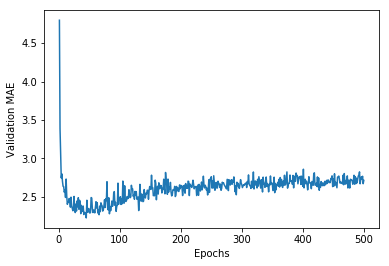

In [71]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。  
我们来重新绘制一张图。

 删除前 10 个数据点，因为它们的取值范围与曲线上的其他点不同。  
 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线。

**绘制验证分数(删除前 10 个数据点)**

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation MAE')

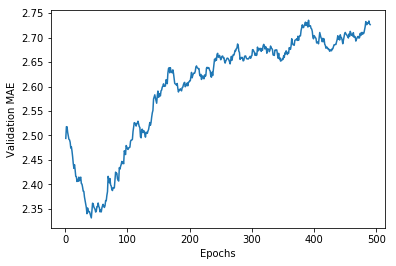

In [72]:
def smooth_curve(points, factor=0.9): 
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: 
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history) 
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从图 3-13 可以看出，验证 MAE 在 80 轮后不再显著降低，之后就开始过拟合。

完成模型调参之后(除了轮数，还可以调节隐藏层大小)，你可以使用最佳参数在所有训练数据上训练最终的生产模型，然后观察模型在测试集上的性能。

**训练最终模型**

In [73]:
model = build_model()  # 一个全新的编译好的模型
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0) # 在所有训练数据上训练模型
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


最终结果如下。

In [74]:
test_mae_score

2.6805789423923865

你预测的房价还是和实际价格相差约 2550 美元。

### 3.6.5 小结

下面是你应该从这个例子中学到的要点。

 1、回归问题使用的损失函数与分类问题不同。回归常用的损失函数是均方误差(MSE)。  
 2、同样，回归问题使用的评估指标也与分类问题不同。显而易见，精度的概念不适用于回归问题。常见的回归指标是平均绝对误差(MAE)。  
 3、如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放。  
 4、如果可用的数据很少，使用 K 折验证可以可靠地评估模型。  
 5、如果可用的训练数据很少，最好使用隐藏层较少(通常只有一到两个)的小型网络，以避免严重的过拟合。  

## 3.7 本章小结

In [ ]:
'''
1、现在你可以处理关于向量数据最常见的机器学习任务了:二分类问题、多分类问题和标量回归问题。前面三节的“小结”总结了你从这些任务中学到的要点。
2、在将原始数据输入神经网络之前，通常需要对其进行预处理。
3、如果数据特征具有不同的取值范围，那么需要进行预处理，将每个特征单独缩放。
4、随着训练的进行，神经网络最终会过拟合，并在前所未见的数据上得到更差的结果。
5、如果训练数据不是很多，应该使用只有一两个隐藏层的小型网络，以避免严重的过拟合。
6、如果数据被分为多个类别，那么中间层过小可能会导致信息瓶颈。
7、回归问题使用的损失函数和评估指标都与分类问题不同。
8、如果要处理的数据很少，K 折验证有助于可靠地评估模型。
'''